In [64]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [101]:
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import BaggingRegressor

In [80]:
from utils import read_features, read_targets, metrics_r, combine_features

## Read Features and Targets

In [4]:
path = os.path.abspath(os.path.join(os.getcwd(), "../../data/chronology_prediction"))

In [5]:
X = read_features(path)

Loaded X_train_tfidf
Loaded X_train_bert
Loaded X_train_cannyhog
Loaded X_train_resnet
Loaded X_train_vit
Loaded X_test_tfidf
Loaded X_test_bert
Loaded X_test_cannyhog
Loaded X_test_resnet
Loaded X_test_vit


In [6]:
y = read_targets(path, ["StartYear", "YearRange"])

Loaded y_train
Loaded y_test


## Load Best Parameters from HP Tuning

In [7]:
path_params = "best_params.json"
with open(path_params, "r") as f:
    best_params = json.load(f)
    best_params = {
        model: {
            eval(k): v for k, v in param_dict.items()
        } for model, param_dict in best_params.items()
    }

## SMTH

In [8]:
# best_models = pd.read_csv("best_models.csv")
# for _, row in best_models.iterrows():
#     if row["data_type"] == "combo":
#         feature_sets = []
#         for part in row["features"].split(" + "):
#             feature_sets.append(X)

In [104]:
def predict_with_std(model, X_test):
    # Get predictions from all estimators
    estimators = model.estimators_
    all_preds = np.stack([est.predict(X_test) for est in estimators])

    y_pred = np.mean(all_preds, axis=0)
    y_std = np.std(all_preds, axis=0)  # Uncertainty

    return y_pred, y_std


In [59]:
def evaluate(y_true, y_pred):
    scores = {}
    for metric, get_metric_score in metrics_r.items():
        metric_score = get_metric_score(y_true, y_pred)
        if metric == "rmse": metric_score = np.sqrt(metric_score)
        # print(f"{metric} = {metric_score}")
        scores[metric] = float(metric_score)
    return scores

In [68]:
def get_result_table(y_true, y_pred, y_std, N=10):
    results = pd.DataFrame({"y_true": y["test"][target], "y_pred": y_pred, "y_std": y_std})

    # Assume the prediction errors follow a normal distribution
    # Confidence Interval where prediction has 95% confidence
    z = norm.ppf(0.975)  # ≈ 1.96
    results["CI_lower"] = results["y_pred"] - z * results["y_std"]
    results["CI_upper"] = results["y_pred"] + z * results["y_std"]

    # Probability that the true year lies within ±N years of prediction
    def fixed_CI_probability(y_std, N):
        y_std = max(y_std, 1e-6)  # avoid division by zero
        z = N / y_std
        return norm.cdf(z) - norm.cdf(-z)

    results[f"confidence_±{N}"] = results["y_std"].apply(
        lambda std: fixed_CI_probability(std, N)
    )
    return results


In [70]:
def plot_true_vs_pred(results, samples):
    if samples > len(results): samples = len(results)
    sample_results_sorted = results.head(samples).sort_values(by="y_true").reset_index(drop=True)

    plt.figure(figsize=(14, samples * 0.2))  # Dynamic height based on # of entries

    for i, row in sample_results_sorted.iterrows():
        # Confidence interval line
        plt.plot([row["CI_lower"], row["CI_upper"]], [i, i], color='gray', linewidth=1, alpha=0.5)

        # True year dot
        plt.scatter(row["y_true"], i, color='green', label='True' if i == 0 else "", zorder=3, s=20)

        # Predicted year dot
        plt.scatter(row["y_pred"], i, color='blue', label='Predicted' if i == 0 else "", zorder=3, s=20)

    plt.ylim(samples, -1)
    plt.yticks([])
    plt.xlabel("Year")
    plt.ylabel("Data Entries")
    plt.title("Prediction vs True Year with Confidence Interval")
    plt.legend(loc="upper right")
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

## Text --> StartYear

In [54]:
model_class = RandomForestRegressor
model_name = "RandomForest"
features = "tfidf"
target = "StartYear"

model = model_class(**best_params[model_name][(features, target)])
model.fit(X["train"][features], y["train"][target])
y_pred, y_std = predict_with_std(model, X["test"][features])

C:\Users\dimit\.conda\envs\thesis\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\dimit\.conda\envs\thesis\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\dimit\.conda\envs\thesis\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\dimit\.conda\envs\thesis\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\dimit\.conda\envs\thesis\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\dimit\.cond

In [60]:
scores = evaluate(y["test"][target], y_pred)
scores

{'mae': 29.72931064572426,
 'rmse': 40.47218366658402,
 'r2': 0.6095885256997997,
 'medae': 22.149999999999977,
 'maxerror:': 135.325}

In [69]:
results = get_result_table(y["test"][target], y_pred, y_std)
results

,y_true,y_pred,y_std,CI_lower,CI_upper,confidence_±10
0,-525.0,-433.290000,56.846336,-544.706771,-321.873229,0.139638
1,-425.0,-460.460000,44.518630,-547.714911,-373.205089,0.177729
2,-375.0,-439.670000,59.032035,-555.370662,-323.969338,0.134518
3,-600.0,-508.150000,34.217357,-575.214787,-441.085213,0.229904
4,-500.0,-495.750000,34.588835,-563.542871,-427.957129,0.227503
...,...,...,...,...,...,...
186,-500.0,-501.300000,19.073804,-538.683969,-463.916031,0.399916
187,-500.0,-448.686667,58.947374,-564.221397,-333.151936,0.134709
188,-500.0,-482.100000,60.754341,-601.176321,-363.023679,0.130739
189,-375.0,-464.700000,62.300963,-586.807644,-342.592356,0.127522


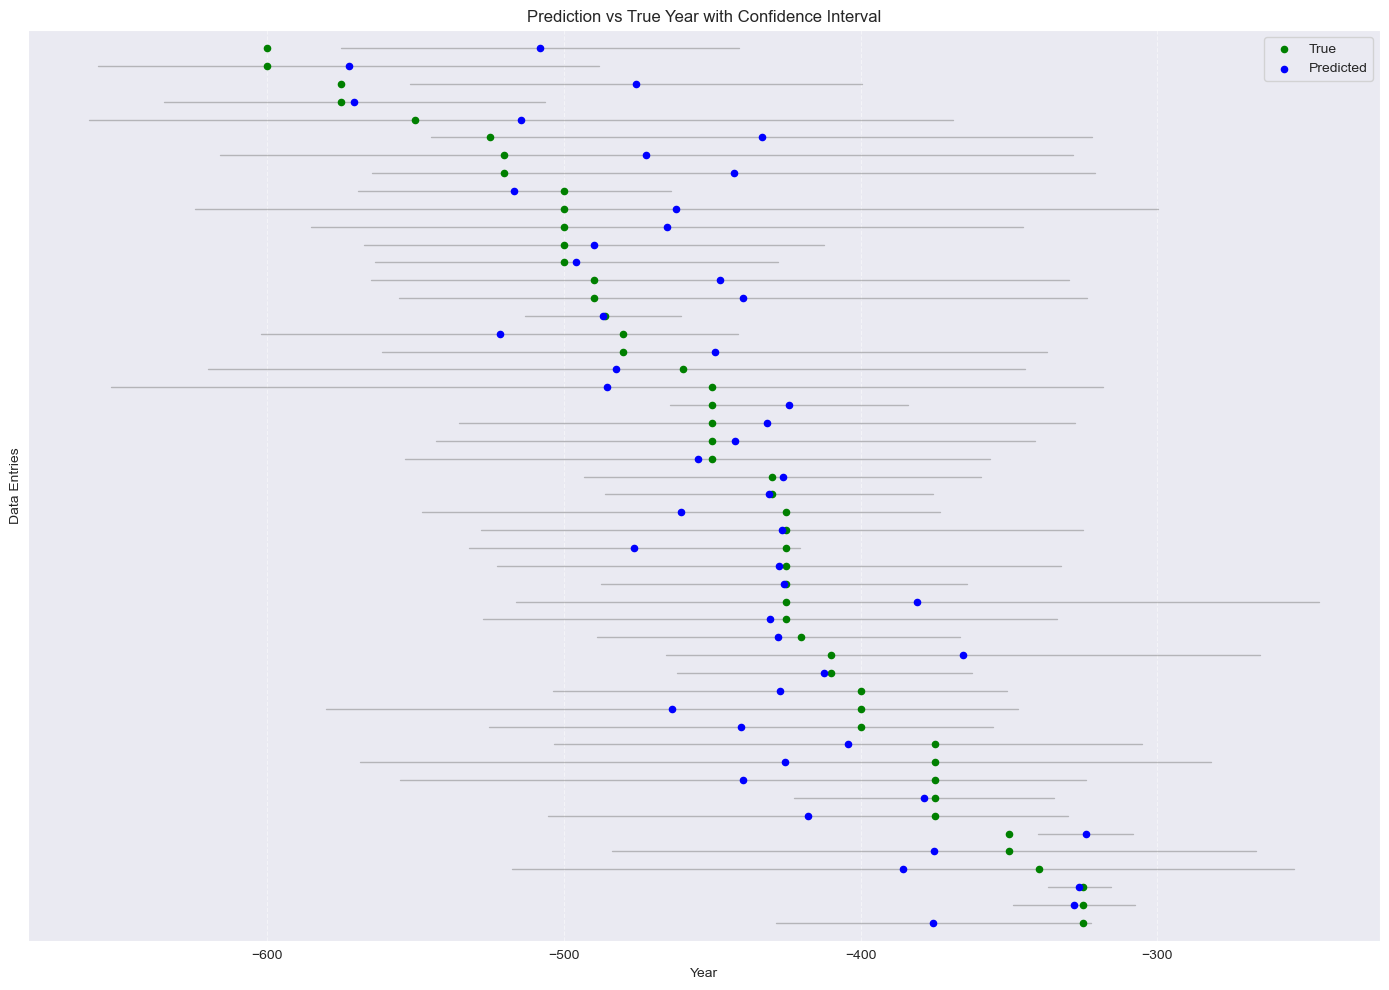

In [71]:
plot_true_vs_pred(results, 50)

## Image --> StartYear

In [74]:
features = "vit"
target = "StartYear"

models = {name: LGBMRegressor(**best_params["LightGBM"][(features, target)], objective="quantile", alpha=alpha) for name, alpha in {"y_pred": 0.5, "CI_lower": 0.025, "CI_upper": 0.975}.items()}
results = {"y_true": y["test"][target]}
for name, model in models.items():
    model.fit(X["train"][features], y["train"][target])
    results[name] = model.predict(X["test"][features])
results = pd.DataFrame(results)
results

,y_true,y_pred,CI_lower,CI_upper
0,-525.0,-521.731396,-575.028558,-325.000000
1,-425.0,-430.000531,-575.000740,-325.000000
2,-375.0,-459.982865,-498.730292,-325.000000
3,-600.0,-554.031177,-625.023137,-325.000000
4,-500.0,-430.000531,-575.000740,-325.000000
...,...,...,...,...
186,-500.0,-452.546128,-507.062832,-323.940555
187,-500.0,-464.521244,-481.428345,-322.852213
188,-500.0,-430.000531,-575.000740,-325.000000
189,-375.0,-430.000531,-575.000740,-325.000000


In [75]:
scores = evaluate(results["y_true"], results["y_pred"])
scores

{'mae': 43.66708114197519,
 'rmse': 58.222390508760384,
 'r2': 0.19204092308743037,
 'medae': 31.74942033912248,
 'maxerror:': 169.99946877202228}

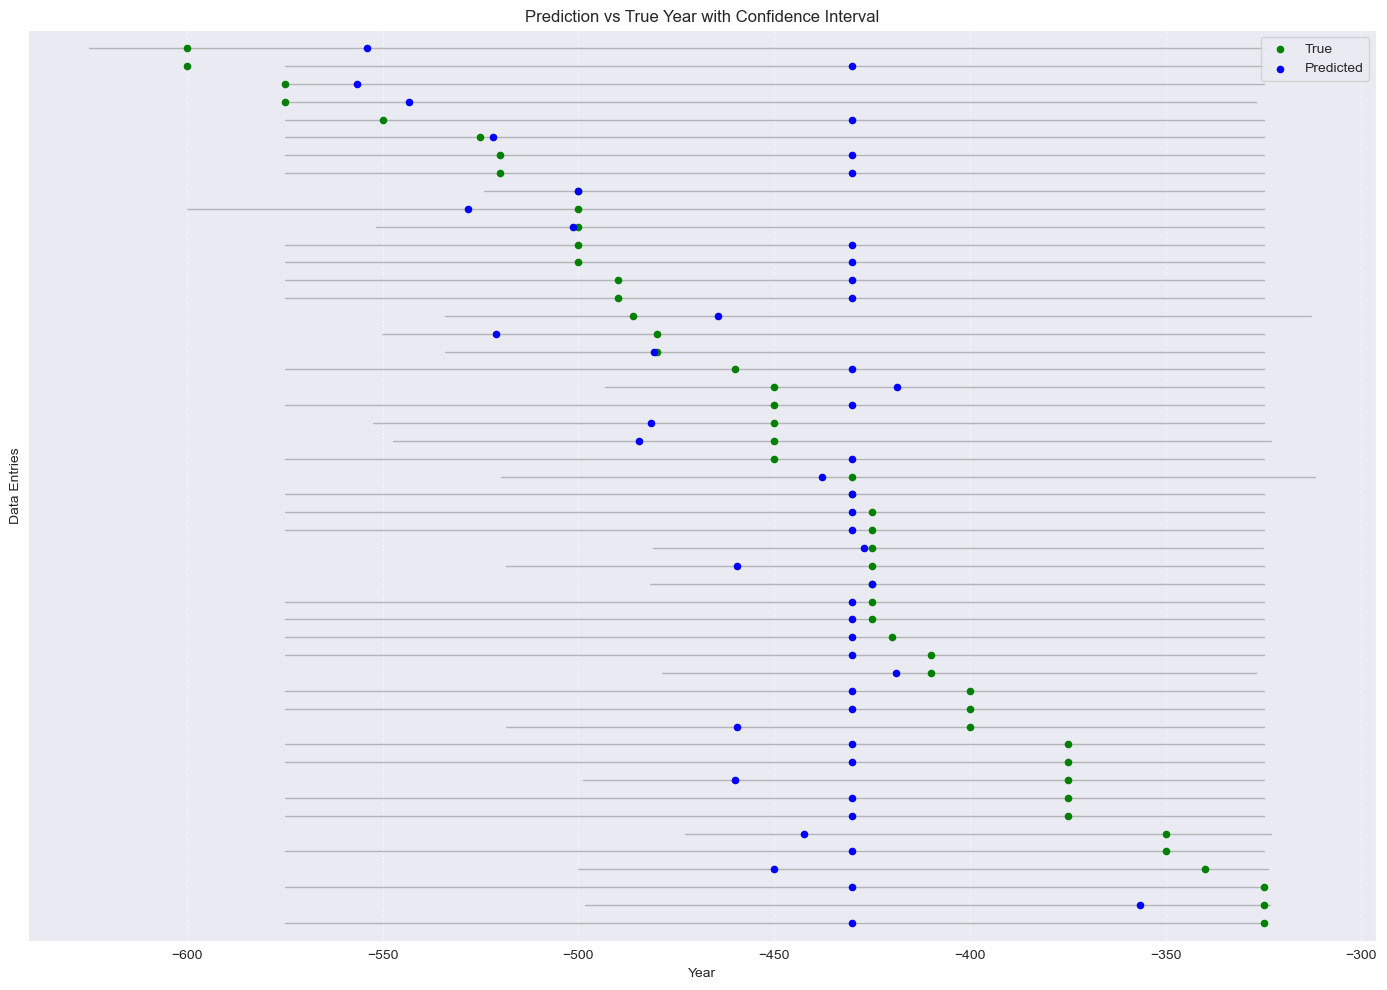

In [76]:
plot_true_vs_pred(results, 50)

## Text+Image Combo --> StartYear

In [81]:
f_txt = "tfidf"
f_img = "vit"
target = "StartYear"

models = {name: LGBMRegressor(**best_params["LightGBM"][(f"{f_txt} + {f_img}", target)], objective="quantile", alpha=alpha) for name, alpha in {"y_pred": 0.5, "CI_lower": 0.025, "CI_upper": 0.975}.items()}
results = {"y_true": y["test"][target]}
for name, model in models.items():
    X_train = combine_features([X["train"][f_txt], X["train"][f_img]])
    X_test = combine_features([X["test"][f_txt], X["test"][f_img]])

    model.fit(X_train, y["train"][target])
    results[name] = model.predict(X_test)

results = pd.DataFrame(results)
results

,y_true,y_pred,CI_lower,CI_upper
0,-525.0,-494.666903,-528.967795,-396.696979
1,-425.0,-429.609255,-513.426570,-358.594343
2,-375.0,-455.476798,-498.498668,-378.306288
3,-600.0,-562.555462,-593.716029,-357.498297
4,-500.0,-489.687637,-517.307929,-350.146097
...,...,...,...,...
186,-500.0,-487.642540,-515.076972,-359.897767
187,-500.0,-454.368990,-513.558917,-378.474027
188,-500.0,-461.131444,-545.263618,-360.526911
189,-375.0,-474.276195,-529.329174,-360.434038


In [82]:
scores = evaluate(results["y_true"], results["y_pred"])
scores

{'mae': 31.741237154225953,
 'rmse': 42.91048980632808,
 'r2': 0.5611296485759226,
 'medae': 23.086699859917758,
 'maxerror:': 156.7891325270084}

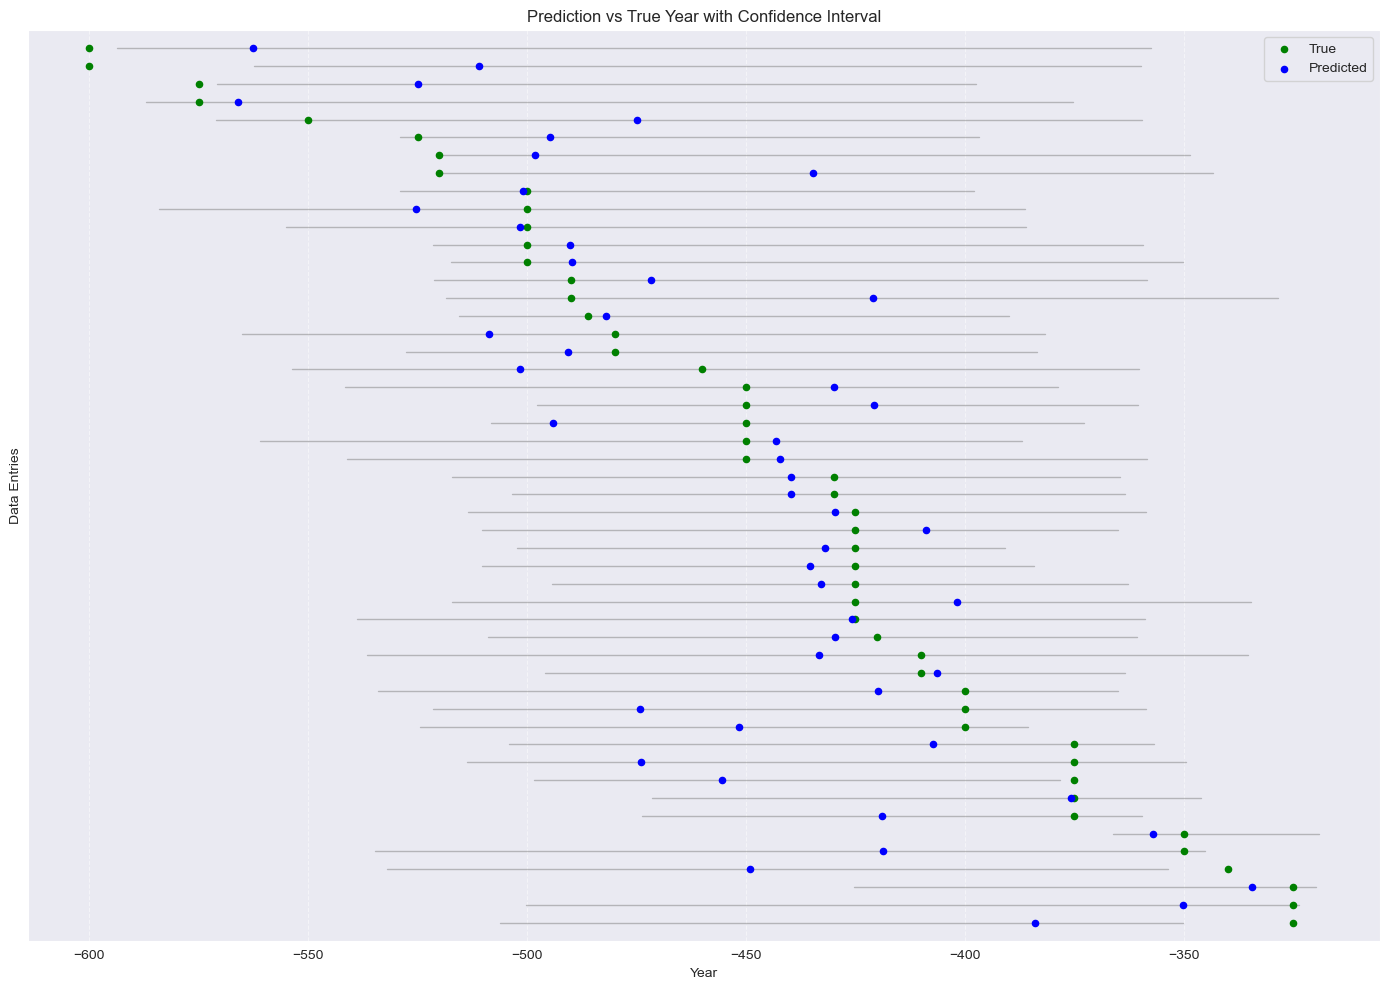

In [83]:
plot_true_vs_pred(results, 50)

## Text --> YearRange

In [84]:
model_class = RandomForestRegressor
model_name = "RandomForest"
features = "tfidf"
target = "YearRange"

model = model_class(**best_params[model_name][(features, target)])
model.fit(X["train"][features], y["train"][target])
y_pred, y_std = predict_with_std(model, X["test"][features])

C:\Users\dimit\.conda\envs\thesis\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\dimit\.conda\envs\thesis\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\dimit\.conda\envs\thesis\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\dimit\.conda\envs\thesis\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\dimit\.conda\envs\thesis\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\dimit\.cond

In [85]:
scores = evaluate(y["test"][target], y_pred)
scores

{'mae': 9.824539566187344,
 'rmse': 11.51714508670036,
 'r2': 0.28461265347494225,
 'medae': 9.941008912938758,
 'maxerror:': 31.531207362910628}

In [86]:
results = get_result_table(y["test"][target], y_pred, y_std)
results

,y_true,y_pred,y_std,CI_lower,CI_upper,confidence_±10
0,0.0,15.178384,11.101693,-6.580535,36.937303,0.632286
1,25.0,11.557712,11.397305,-10.780595,33.896019,0.619731
2,25.0,23.368966,2.480340,18.507588,28.230344,0.999945
3,25.0,17.341210,14.506276,-11.090568,45.772987,0.509401
4,25.0,19.750000,10.182706,-0.207737,39.707737,0.673928
...,...,...,...,...,...,...
186,25.0,21.882851,7.578994,7.028296,36.737407,0.812977
187,20.0,14.191575,10.356184,-6.106174,34.489323,0.665759
188,20.0,16.851790,12.630662,-7.903854,41.607433,0.571478
189,50.0,24.278657,8.796849,7.037149,41.520165,0.744366


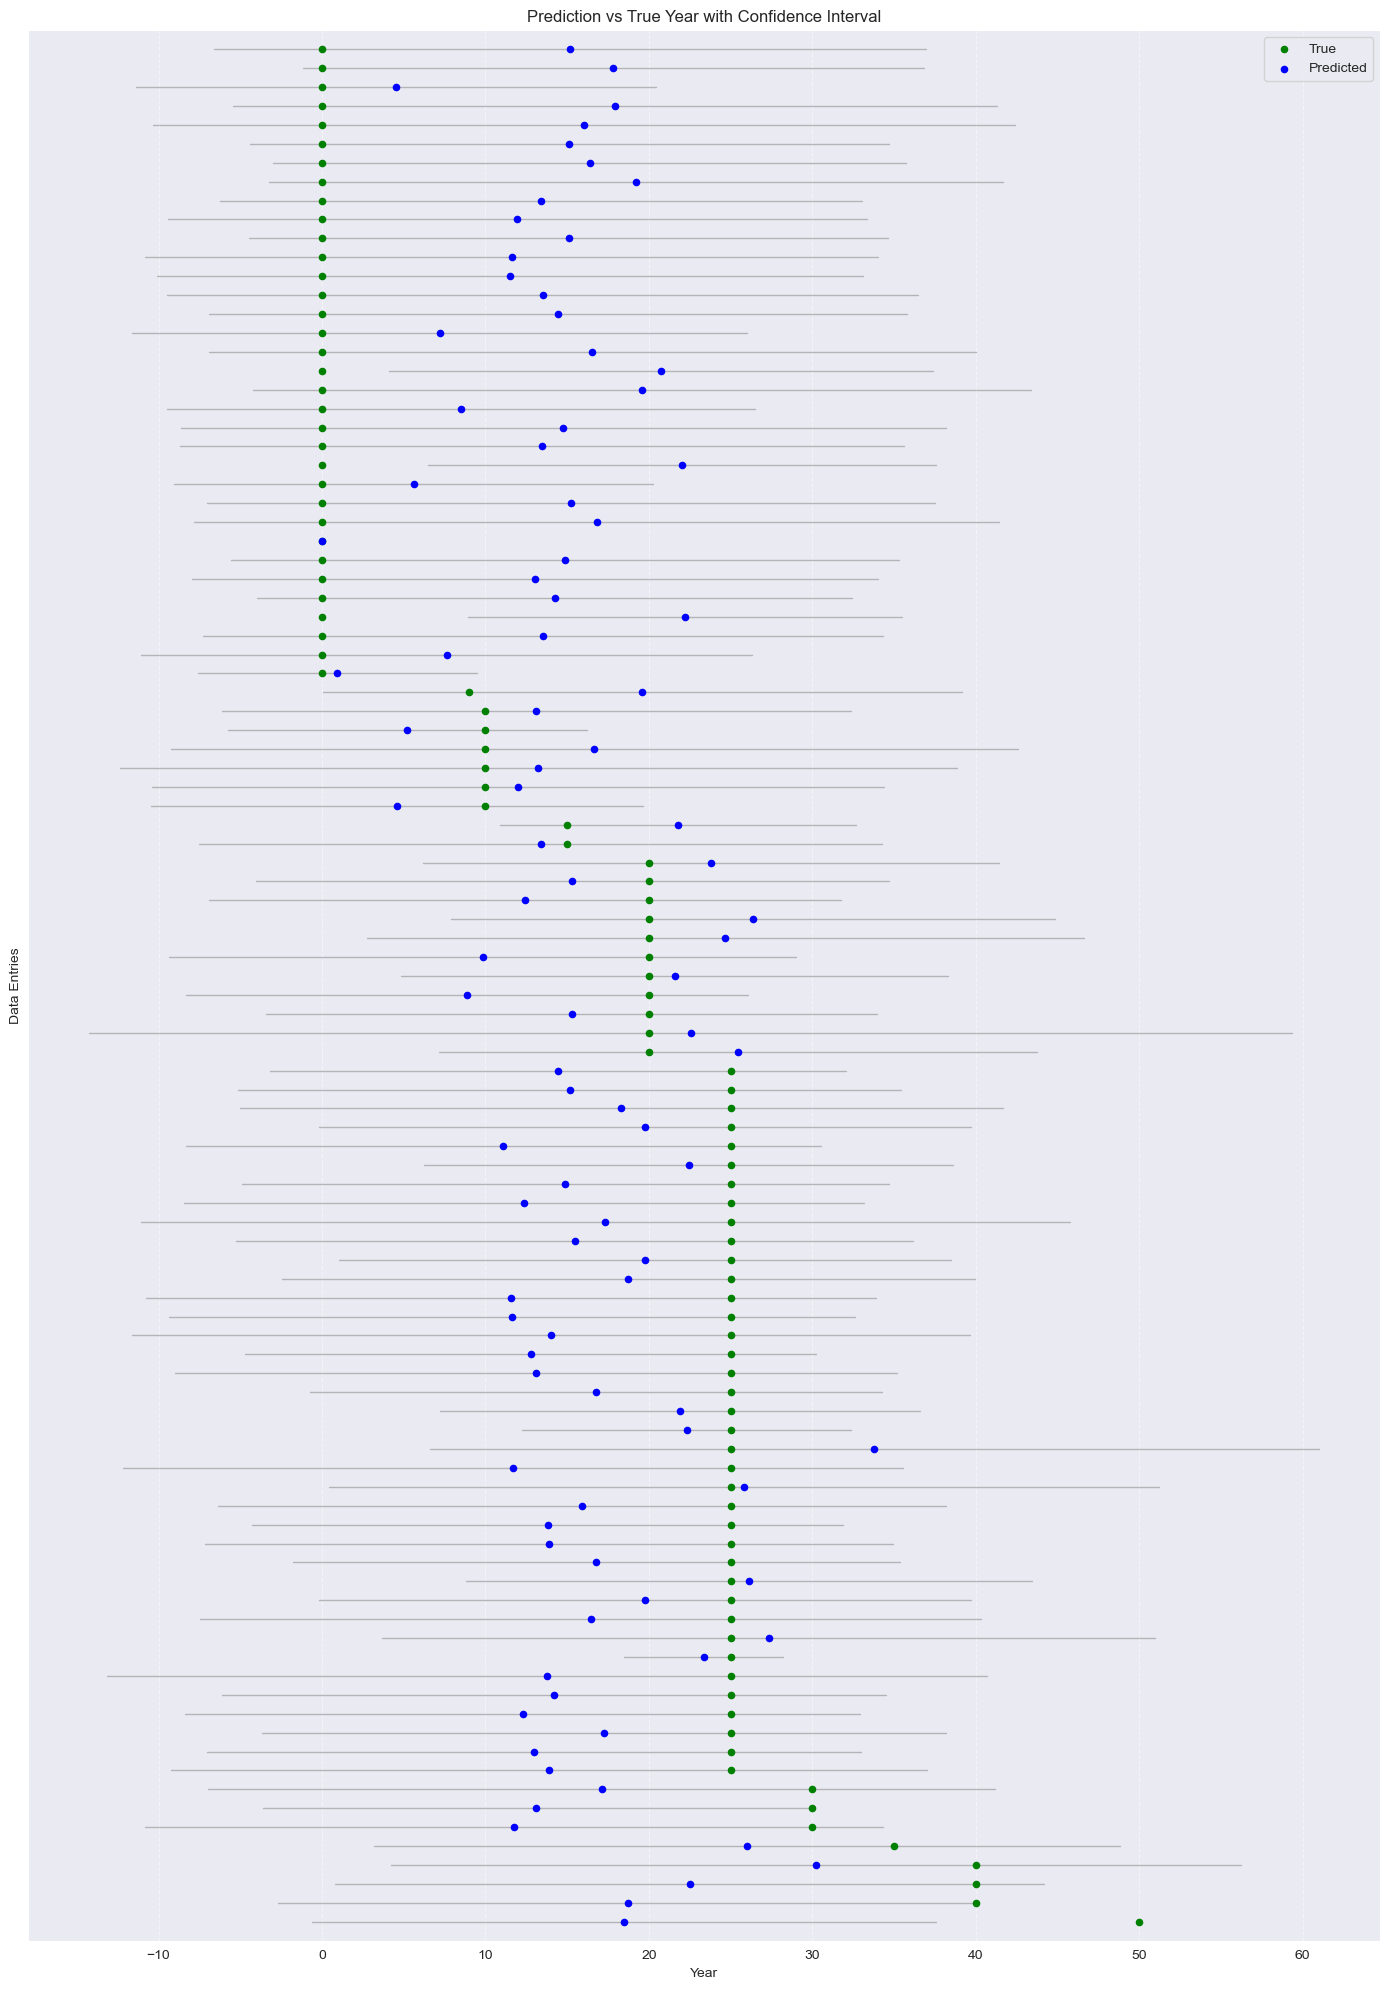

In [88]:
plot_true_vs_pred(results, 100)

## Image --> YearRange

In [105]:
features = "vit"
target = "YearRange"

model = BaggingRegressor(estimator=Ridge(**best_params["Ridge"][(features, target)]), n_estimators=50, bootstrap=True, n_jobs=-1)
model.fit(X["train"][features], y["train"][target])
y_pred, y_std = predict_with_std(model, X["test"][features])

C:\Users\dimit\.conda\envs\thesis\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
C:\Users\dimit\.conda\envs\thesis\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
C:\Users\dimit\.conda\envs\thesis\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
C:\Users\dimit\.conda\envs\thesis\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
C:\Users\dimit\.conda\envs\thesis\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
C:\Users\dimit\.conda\envs\thesis\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X

In [106]:
scores = evaluate(y["test"][target], y_pred)
scores

{'mae': 11.121109173845499,
 'rmse': 12.829299621330822,
 'r2': 0.11231787554442862,
 'medae': 8.383880085960865,
 'maxerror:': 33.38071260313935}

In [107]:
results = get_result_table(y["test"][target], y_pred, y_std)
results

,y_true,y_pred,y_std,CI_lower,CI_upper,confidence_±10
0,0.0,17.648564,2.943939,11.878549,23.418578,0.999318
1,25.0,16.619287,0.433457,15.769727,17.468848,1.000000
2,25.0,22.605823,1.827666,19.023663,26.187983,1.000000
3,25.0,20.358324,3.525996,13.447499,27.269149,0.995433
4,25.0,16.619287,0.433457,15.769727,17.468848,1.000000
...,...,...,...,...,...,...
186,25.0,11.356697,2.905914,5.661211,17.052183,0.999421
187,20.0,13.784891,3.506351,6.912569,20.657213,0.995655
188,20.0,16.619287,0.433457,15.769727,17.468848,1.000000
189,50.0,16.619287,0.433457,15.769727,17.468848,1.000000


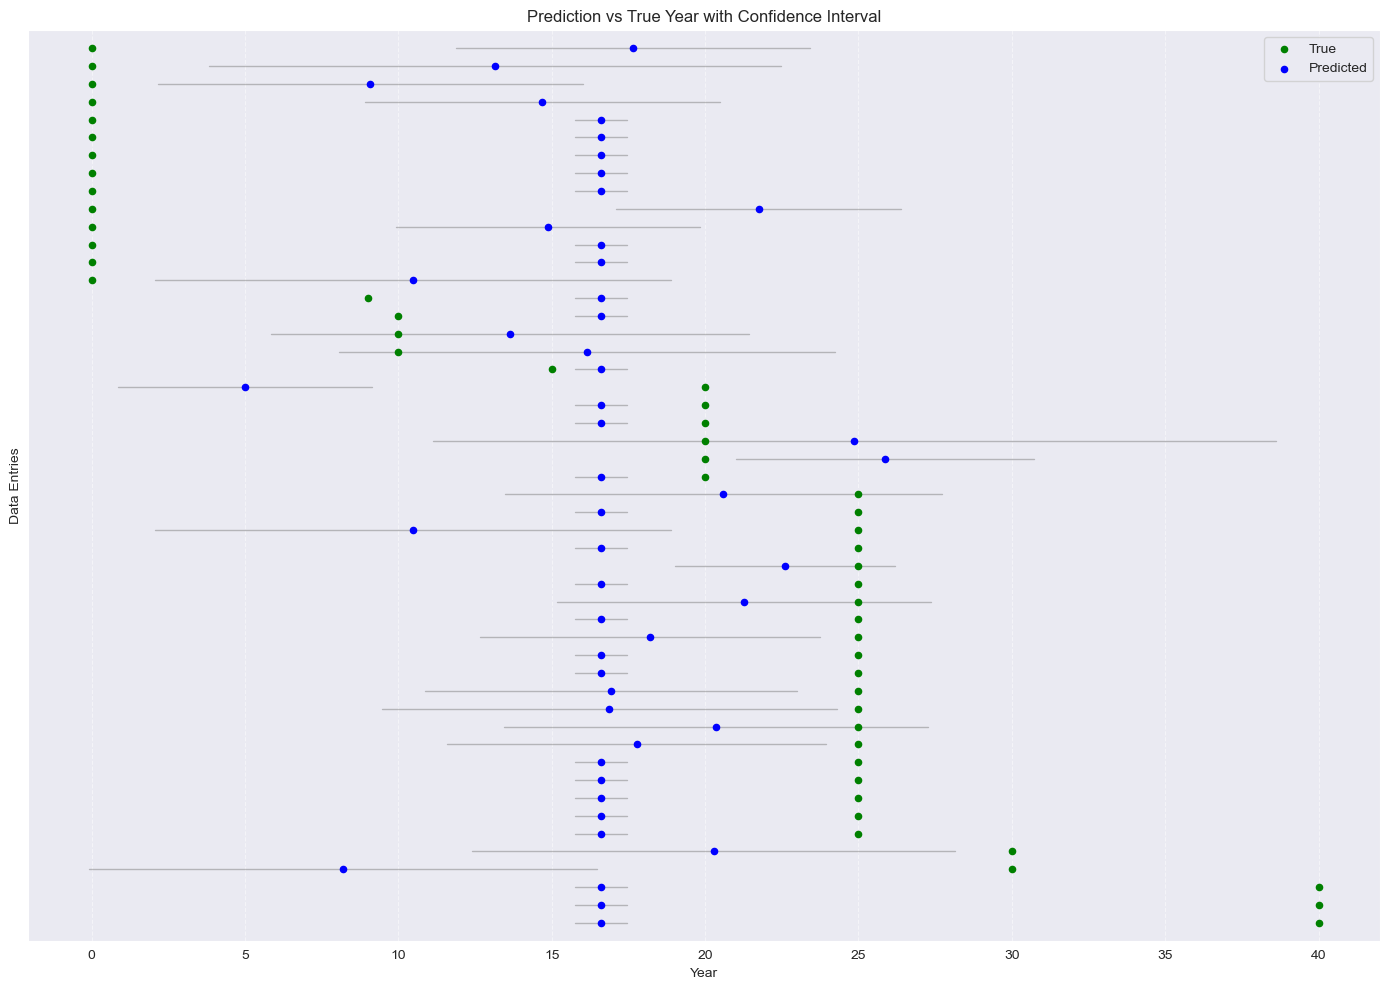

In [109]:
plot_true_vs_pred(results, 50)

## Text + Image Combo --> YearRange

In [110]:
model_class = RandomForestRegressor
model_name = "RandomForest"
f_txt = "tfidf"
f_img = "resnet"
target = "YearRange"

model = model_class(**best_params[model_name][(f"{f_txt} + {f_img}", target)])

X_train = combine_features([X["train"][f_txt], X["train"][f_img]])
X_test = combine_features([X["test"][f_txt], X["test"][f_img]])

model.fit(X_train, y["train"][target])
y_pred, y_std = predict_with_std(model, X_test)

C:\Users\dimit\.conda\envs\thesis\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\dimit\.conda\envs\thesis\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\dimit\.conda\envs\thesis\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\dimit\.conda\envs\thesis\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\dimit\.conda\envs\thesis\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\dimit\.cond

In [111]:
scores = evaluate(y["test"][target], y_pred)
scores

{'mae': 9.69481814593202,
 'rmse': 11.418703879219295,
 'r2': 0.29678973828312893,
 'medae': 9.253333333333334,
 'maxerror:': 28.2922619047619}

In [112]:
results = get_result_table(y["test"][target], y_pred, y_std)
results

,y_true,y_pred,y_std,CI_lower,CI_upper,confidence_±10
0,0.0,16.082500,13.002860,-9.402638,41.567638,0.558143
1,25.0,13.937024,13.107028,-11.752279,39.626327,0.554506
2,25.0,21.990000,5.732065,10.755359,33.224641,0.918941
3,25.0,28.033333,17.497770,-6.261665,62.328332,0.432340
4,25.0,16.400000,10.514131,-4.207318,37.007318,0.658447
...,...,...,...,...,...,...
186,25.0,19.939762,10.395205,-0.434465,40.313989,0.663941
187,20.0,9.269167,9.900799,-10.136042,28.674375,0.687514
188,20.0,15.763393,12.938568,-9.595735,41.122521,0.560408
189,50.0,23.458452,9.810723,4.229789,42.687115,0.691936


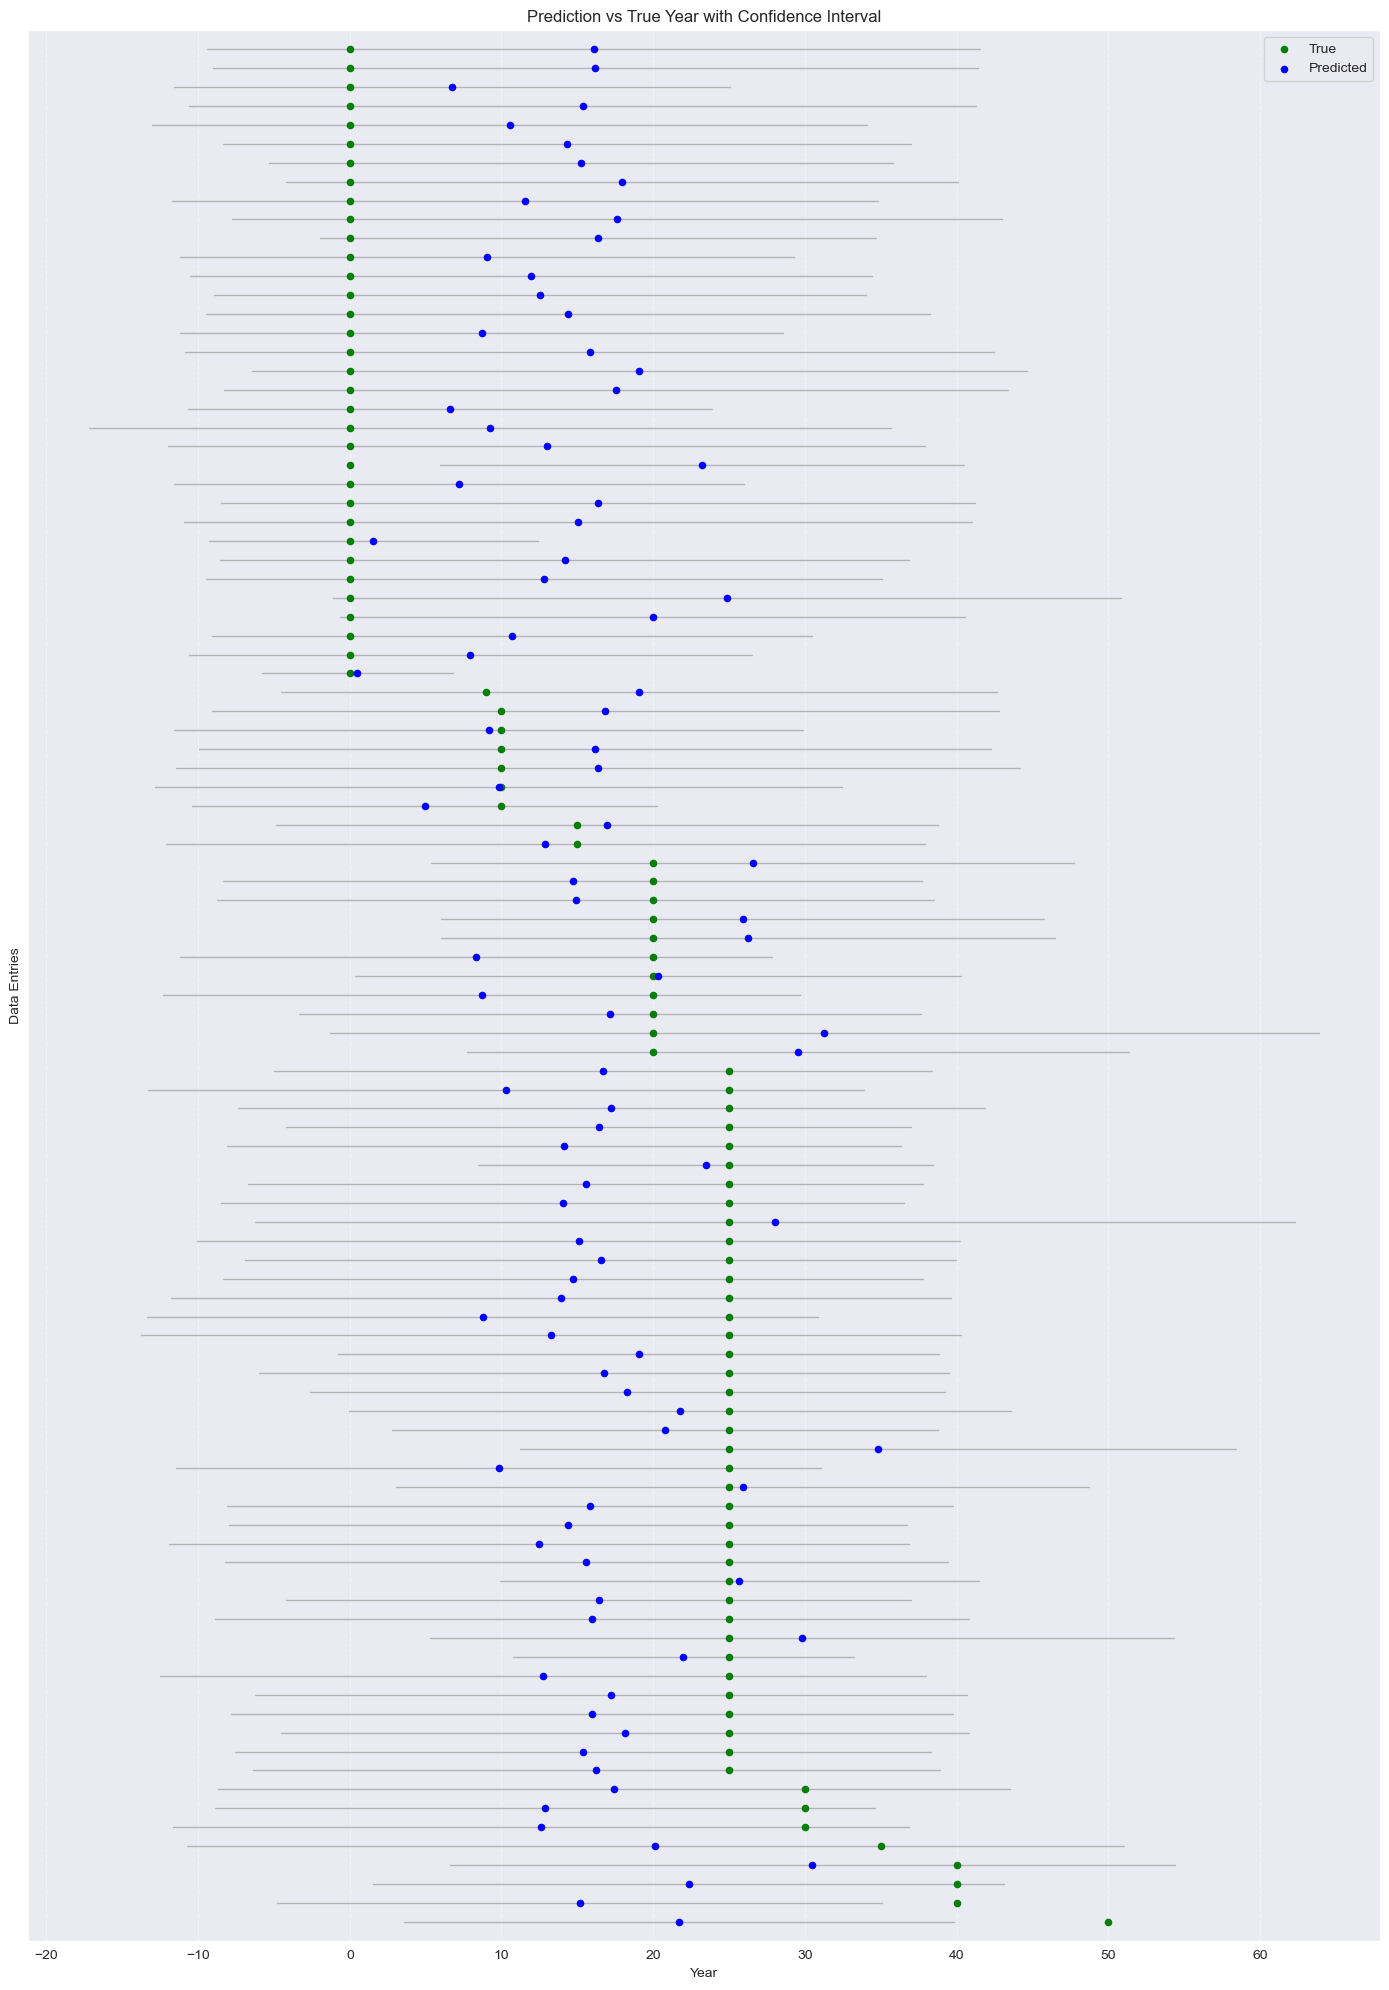

In [113]:
plot_true_vs_pred(results, 100)